# Querying On-Disk Tables

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.031 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 35.016 MiB


## Load movielens datasets in pandas DataFrames

Let's start loadind dataset in pandas so that we can create persistent versions more easily later on.

In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.008 MiB RAM in 0.002s, peaked 0.016 MiB above current, total RAM usage 35.023 MiB


In [3]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 68.953 MiB RAM in 0.632s, peaked 3.414 MiB above current, total RAM usage 103.977 MiB


In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 121.246 MiB RAM in 4.475s, peaked 122.930 MiB above current, total RAM usage 225.223 MiB


In [5]:
# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 85.203 MiB RAM in 0.088s, peaked 0.000 MiB above current, total RAM usage 310.426 MiB


In [6]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 61.121 MiB RAM in 0.181s, peaked 0.000 MiB above current, total RAM usage 371.547 MiB


In [7]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [7] used 38.664 MiB RAM in 5.212s, peaked 107.867 MiB above current, total RAM usage 410.211 MiB


In [8]:
# Get rid of unnecessary containers to save memory
del movies, ratings

In [8] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 410.234 MiB


In [9]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 42.4 ms


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.160 MiB RAM in 0.052s, peaked 0.000 MiB above current, total RAM usage 410.395 MiB


In [10]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
qtime_pandas_mem

0.05178499221801758

In [10] used 0.023 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 410.418 MiB


## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk using exactly the same API.  Let's try that.

In [11]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4hc'
bcolz.defaults.cparams['clevel'] = 6
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.0rc2
NumPy version:     1.10.4
Blosc version:     1.8.0 ($Date:: 2016-03-31 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.5.1
Python version:    2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [11] used 5.207 MiB RAM in 0.058s, peaked 0.000 MiB above current, total RAM usage 415.625 MiB


In [12]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [12] used 0.699 MiB RAM in 2.499s, peaked 78.203 MiB above current, total RAM usage 416.324 MiB


In [13]:
%time result = zlens["(title == b'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result

CPU times: user 96 ms, sys: 12 ms, total: 108 ms
Wall time: 99.6 ms


array([  75, 3842, 6031])

In [13] used 0.016 MiB RAM in 0.104s, peaked 0.000 MiB above current, total RAM usage 416.340 MiB


In [14]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [14] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 416.340 MiB


In [15]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 74.1 ms
In [15] used 0.000 MiB RAM in 0.076s, peaked 0.000 MiB above current, total RAM usage 416.340 MiB


In [16]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [16] used 0.004 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 416.344 MiB


Let's see the space consumed on-disk:

In [17]:
!du -sh $bcolz_dir

6,0M	movielens-denorm.bcolz
In [17] used 0.281 MiB RAM in 0.112s, peaked 0.000 MiB above current, total RAM usage 416.625 MiB


and let's compare it with the internal estimated size:

In [18]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.08 MB; ratio: 21.69
  cparams := cparams(clevel=6, shuffle=2, cname='lz4hc')
  rootdir := 'movielens-denorm.bcolz'
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [18] used 0.012 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 416.637 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which means that bcolz offers a conservative guess in general.

Another interesting fact is that the de-normalized version of the ctable takes less space than the normalized version in a relational database, and the query speed is still faster (than SQLite at least).

But there are other ways to store compressed tables.  Let's visit PyTables and see how it performs.

## PyTables

In [19]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [19] used 2.777 MiB RAM in 8.771s, peaked 0.000 MiB above current, total RAM usage 419.414 MiB


In [20]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [20] used -2.012 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 417.402 MiB


In [21]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4hc(6)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "title": StringCol(itemsize=82, shape=(), dflt='', pos=1),
  "genres": StringCol(itemsize=47, shape=(), dflt='', pos=2),
  "user_id": Int64Col(shape=(), dflt=0, pos=3),
  "rating": Int64Col(shape=(), dflt=0, pos=4),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (1628,)

In [21] used 0.008 MiB RAM in 0.074s, peaked 0.000 MiB above current, total RAM usage 417.410 MiB


In [22]:
%time result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 192 ms, sys: 16 ms, total: 208 ms
Wall time: 187 ms
In [22] used 0.012 MiB RAM in 0.189s, peaked 0.000 MiB above current, total RAM usage 417.422 MiB


In [23]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [23] used 0.016 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 417.438 MiB


So, it seems that PyTables has a similar performance than SQLite for the queries (200 ms vs 170 ms for the denormalized case).  What about the size of the HDF5 file?

In [24]:
h5file.close()
!ls -lh $h5denorm

-rw-rw-r-- 1 faltet faltet 6,0M abr  5 11:18 movielens-denorm.h5
In [24] used 0.000 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 417.438 MiB


6.0 MB is approximately the same than the 6.0 MB that used bcolz (which is expected because both are using LZ4HC as the compressor).

## Indexing (PyTables)

PyTables can index tables for improving query speed.  Let's try out:

In [25]:
## Copy the original PyTables table into another file
import shutil
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

In [25] used 0.027 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 417.465 MiB


In [26]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [26] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.484 MiB


In [27]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [27] used 0.141 MiB RAM in 4.877s, peaked 120.980 MiB above current, total RAM usage 417.625 MiB


In [28]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 4.9 ms per loop
In [28] used 0.035 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 417.660 MiB


In [29]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [29] used 0.020 MiB RAM in 0.079s, peaked 0.000 MiB above current, total RAM usage 417.680 MiB


So, by indexing one column we have got a 60x of acceleration wrt PyTables (5 ms vs 300 ms).  What happens if we index the 'rating' column?

In [30]:
h5lens.cols.rating.create_csindex()

1000209

In [30] used 0.074 MiB RAM in 0.818s, peaked 0.000 MiB above current, total RAM usage 417.754 MiB


In [31]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 1.54 ms per loop
In [31] used 0.023 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 417.777 MiB


In [32]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [32] used 0.000 MiB RAM in 0.032s, peaked 0.000 MiB above current, total RAM usage 417.777 MiB


Ok, that's another ~3x additional acceleration, and the best time that we ever reached for this query.

In [33]:
h5i.close()

In [33] used 0.023 MiB RAM in 0.093s, peaked 0.000 MiB above current, total RAM usage 417.801 MiB


## Querying on-disk data with SQLite (relational database)

In [34]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [34] used -0.074 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 417.727 MiB


In [35]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 112 ms, sys: 16 ms, total: 128 ms
Wall time: 126 ms
In [35] used 0.004 MiB RAM in 0.128s, peaked 0.000 MiB above current, total RAM usage 417.730 MiB


In [36]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [36] used 0.004 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 417.734 MiB


In [37]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [37] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.734 MiB


In [38]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 372 ms, sys: 32 ms, total: 404 ms
Wall time: 403 ms
In [38] used 0.000 MiB RAM in 0.405s, peaked 0.000 MiB above current, total RAM usage 417.734 MiB


In [39]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [39] used 0.148 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 417.883 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [40]:
!ls -lh $sqlite_norm $sqlite_denorm

-rw-r--r-- 1 faltet faltet 78M abr  5 11:18 movielens-denorm.sqlite
-rw-r--r-- 1 faltet faltet 37M abr  5 11:18 movielens-norm.sqlite
In [40] used 0.000 MiB RAM in 0.242s, peaked 0.000 MiB above current, total RAM usage 417.883 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  But indexing is the strongest point of relational databases, so let's see how it can accelerate queries:

## Indexing (SQLite)

In [41]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [41] used 0.000 MiB RAM in 0.079s, peaked 0.000 MiB above current, total RAM usage 417.883 MiB


In [42]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [42] used 0.004 MiB RAM in 2.567s, peaked 30.742 MiB above current, total RAM usage 417.887 MiB


In [43]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]
# keep the run-time for reference
qtime_sqlite_index1 = t.best

1 loop, best of 1: 490 µs per loop
In [43] used 0.020 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 417.906 MiB


In [44]:
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [44] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.906 MiB


Wow, with quite less than 1 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.

## Exercise

What will happen if index the rating column?  We should get better speed, right?  Try it out and report the improvement that you are seeing.

### Solution

In [45]:
c.execute("CREATE INDEX index_rating ON lens (rating)")
conn_idx.commit()

In [45] used 0.000 MiB RAM in 0.732s, peaked 7.328 MiB above current, total RAM usage 417.906 MiB


In [46]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loop, best of 1: 159 ms per loop
In [46] used 0.000 MiB RAM in 0.163s, peaked 0.000 MiB above current, total RAM usage 417.906 MiB


Uh, we are getting far worse performance with 2 indexes. Take away lesson: indexing is a tricky thing and the best way to assess the improvement in performance is by trying it out, so do not blindly index everthing.

## Final performance comparison

In [47]:
%matplotlib inline

In [47] used -23.254 MiB RAM in 0.145s, peaked 0.000 MiB above current, total RAM usage 394.652 MiB


/home/faltet/miniconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


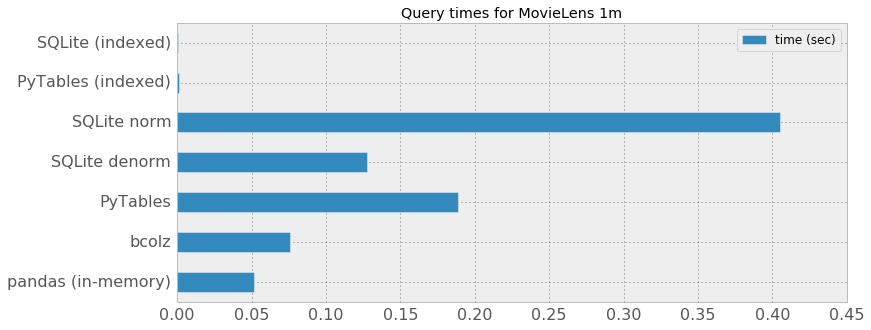

In [48] used 6.531 MiB RAM in 0.306s, peaked 0.000 MiB above current, total RAM usage 401.184 MiB


In [48]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "SQLite norm", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_sqlite_norm, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [49]:
!du -sh movielens* | sort -n

5,8M	movielens-1m
6,0M	movielens-denorm.bcolz
6,0M	movielens-denorm.h5
9,9M	movielens-indexed.h5
37M	movielens-norm.sqlite
78M	movielens-denorm.sqlite
119M	movielens-indexed.sqlite
In [49] used 0.000 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 401.184 MiB


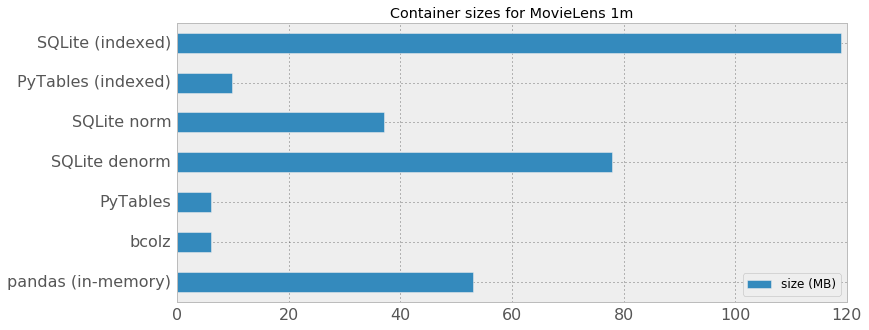

In [50] used 1.055 MiB RAM in 0.295s, peaked 0.000 MiB above current, total RAM usage 402.238 MiB


In [50]:
# Container sizes
df = pd.DataFrame({'size (MB)': [53, 6.0, 6.0, 78, 37, 9.9, 119]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Final Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, but requires lots of storage.  Supports indexing.  Excellent query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so a wise thing to do is to know them better and try to apply the best candidate to your scenario.

Hope that helped and **enjoy data**.